# Levenshtein Distance and Word Similarity Test Cases
In this notebook we explore the problem of word similarity and transforming one word into other using insertions, delations or exhanges. We will use a corpus ow words with the frequency in the english language and build a matrix for the Levenshtein metric. This will allow us to look for words that are separated by exaclty one unit. We can randomly choose among candidates if there are more than one and therfore we can build a path between two given words. Since we are using words that have some meaning (i.e. in the corpus) ofern we don't have a path between arbitrary words. The size of the corpus is very large so for the sake of computation resources we limeted our problem to the most frequent words, ignoring the long tail of unfrequnt words and we focused on words of fixed length (i.e 4)

We have used a few corpuses of words and dictionaries
- Word List from https://www.bragitoff.com/2016/03/english-dictionary-in-csv-format/
- Levenshtein python library: https://maxbachmann.github.io/Levenshtein/
- https://www.kaggle.com/datasets/rtatman/english-word-frequency

In [ ]:
#pip install levenshtein

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from matplotlib import animation
import matplotlib.cm as cm
import glob, os
from Levenshtein import distance
from tqdm import tqdm
import networkx as nx

In [2]:
# reading the data form the Google Corpus
df_freq = pd.read_csv('data/unigram_freq.csv')

In [4]:
df_freq.shape

(333333, 2)

In [11]:
# we notice that the frequency is the raw count. We could add an actual frequency. Additionally we will add the length of the word
df_freq.head()

,word,count,frequency,length
0,the,23135851162,0.039338,3.0
1,of,13151942776,0.022363,2.0
2,and,12997637966,0.022100,3.0
3,to,12136980858,0.020637,2.0
4,a,9081174698,0.015441,1.0


In [7]:
df_freq['frequency'] = df_freq['count']/df_freq['count'].sum()

In [10]:
df_freq['length'] = df_freq['word'].str.len()

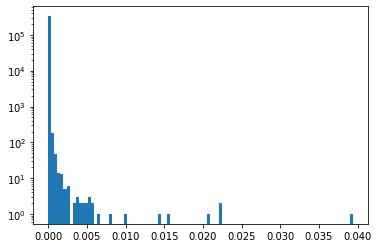

In [8]:
plt.hist(df_freq['frequency'],bins=100,log=True)
plt.show()

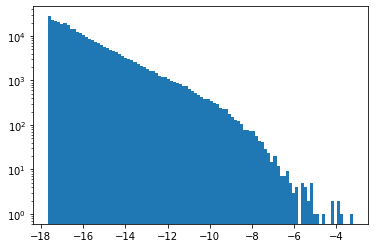

In [27]:
plt.hist(np.log(df_freq['frequency']),bins=100,log=True)
plt.show()

In [33]:
df_freq[np.log(df_freq['frequency']) > -10].shape

(2923, 4)

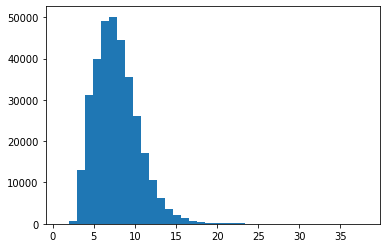

In [15]:
plt.hist(df_freq['length'],bins = int(np.max(df_freq['length'])))
plt.show()

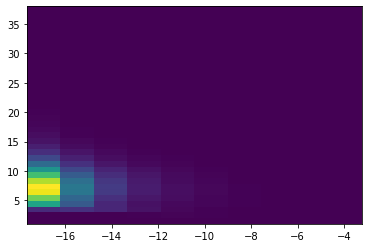

In [26]:
plt.hist2d(np.log(df_freq.dropna()['frequency']),df_freq.dropna()['length'],bins=(10,int(np.max(df_freq['length']))))
plt.show()

In [72]:
# selecting words of length 4 that are relatively frequent (removing the long tail)
df_freq4_log12 = df_freq[(df_freq['length']==4)&(np.log(df_freq['frequency'])>= -12)]

In [73]:
df_freq4_log12.shape

(1322, 4)

In [74]:
df_freq4_log12

,word,count,frequency,length
9,that,3400031103,0.005781,4.0
11,this,3228469771,0.005489,4.0
12,with,3183110675,0.005412,4.0
20,from,2275595356,0.003869,4.0
23,your,2062066547,0.003506,4.0
...,...,...,...,...
12312,nash,3622689,0.000006,4.0
12314,avid,3621749,0.000006,4.0
12322,bets,3619444,0.000006,4.0
12334,carr,3615873,0.000006,4.0


In [75]:
# defining the distance matrix
M4 = np.zeros((len(df_freq4_log12),len(df_freq4_log12)))

In [76]:
M4

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
for ii in tqdm(range(len(df_freq4_log12))):
    for jj in range(ii):
        lev_dis = distance(np.array(df_freq4_log12['word'])[ii],np.array(df_freq4_log12['word'])[jj])
        
        M4[ii][jj] = lev_dis
        M4[jj][ii] = lev_dis


100%|███████████████████████████████████████| 1322/1322 [00:39<00:00, 33.12it/s]


In [78]:
# defining network from adjacency matrix - connect pairs of nodes only if distance is one
G4 = nx.from_numpy_array((M4==1)*1.)

In [79]:
#number of links in the dataset
np.sum((M4==1)*1.)/2

3119.0

## Test:
We will verify that the words 'thin' and 'this' are in the data set. Then we will compute the shortest distance in the network that should be 1.

In [80]:
'this' in list(df_freq4_log12['word']), 'thin' in list(df_freq4_log12['word'])

(True, True)

In [82]:
np.array(df_freq4_log12['word'])[nx.shortest_path(G4,np.arange(len(df_freq4_log12))[df_freq4_log12['word']=='thin'][0],np.arange(len(df_freq4_log12))[df_freq4_log12['word']=='this'][0],weight='weight')]

array(['thin', 'this'], dtype=object)

Consider now an arbitrary pair of words and look for the path

In [87]:
ii = 200
jj = 100
word_seq = np.array(df_freq4_log12['word'])[nx.shortest_path(G4,ii,jj,weight='weight')]
freq_seq = np.array(df_freq4_log12['frequency'])[nx.shortest_path(G4,ii,jj,weight='weight')]
word_seq, freq_seq

(array(['sony', 'tony', 'tone', 'cone', 'core', 'corn', 'coin', 'join',
        'john'], dtype=object),
 array([1.44202038e-04, 4.08887003e-05, 2.95806930e-05, 7.53237131e-06,
        8.71321725e-05, 1.82337602e-05, 1.71652988e-05, 2.96362224e-04,
        3.39456593e-04]))

In [88]:
word_color = (freq_seq-min(freq_seq))/(max(freq_seq)-min(freq_seq))
word_color

array([0.4117496 , 0.10049381, 0.06642577, 0.        , 0.23981317,
       0.03224046, 0.02902147, 0.87016805, 1.        ])

['well' 'dell' 'deal' 'dean' 'jean' 'joan' 'john']
[1.         0.05917253 0.1570031  0.04325473 0.04139391 0.
 0.54087363]


/var/folders/22/9nvz87t91ylc5tn1tdyzy2y80000gn/T/ipykernel_22070/3906531006.py:24: RuntimeWarning: divide by zero encountered in log
  plt.text(t/len(word_seq),0,word_seq[t],va='center',ha='center',fontsize=10,color = cm.winter(-np.log(word_color[t])))


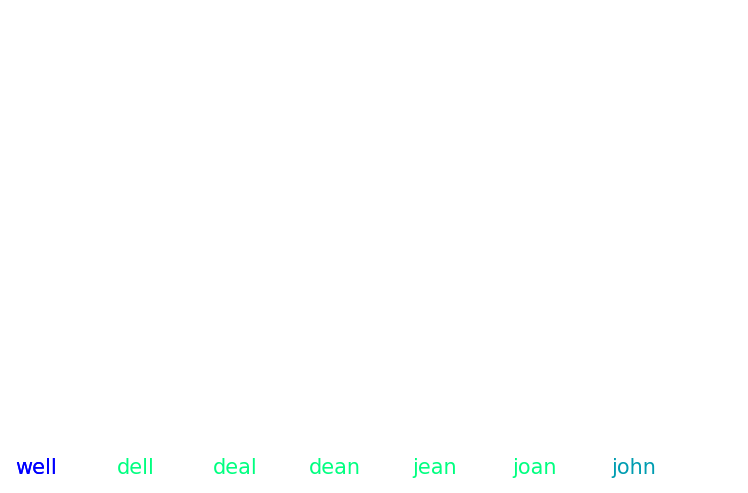

In [98]:
ii = 50
jj = 100
word_seq = np.array(df_freq4_log12['word'])[nx.shortest_path(G4,ii,jj,weight='weight')]
freq_seq = np.array(df_freq4_log12['frequency'])[nx.shortest_path(G4,ii,jj,weight='weight')]
word_color = (freq_seq-min(freq_seq))/(max(freq_seq)-min(freq_seq))



print(word_seq)
print(word_color)


#plt.xlim(-1,len(word_seq)*5)
#plt.ylim(-1,1)


plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

def animate(t):
    #plt.cla()
    plt.text(t/len(word_seq),0,word_seq[t],va='center',ha='center',fontsize=10,color = cm.winter(-np.log(word_color[t])))
    plt.axis('off')
    
anim = animation.FuncAnimation(fig, animate, frames=len(word_seq),interval=500)
anim.save("WordPath_" + word_seq[0] + '_to_' + word_seq[-1] + ".gif", dpi=120, writer="imagemagick")

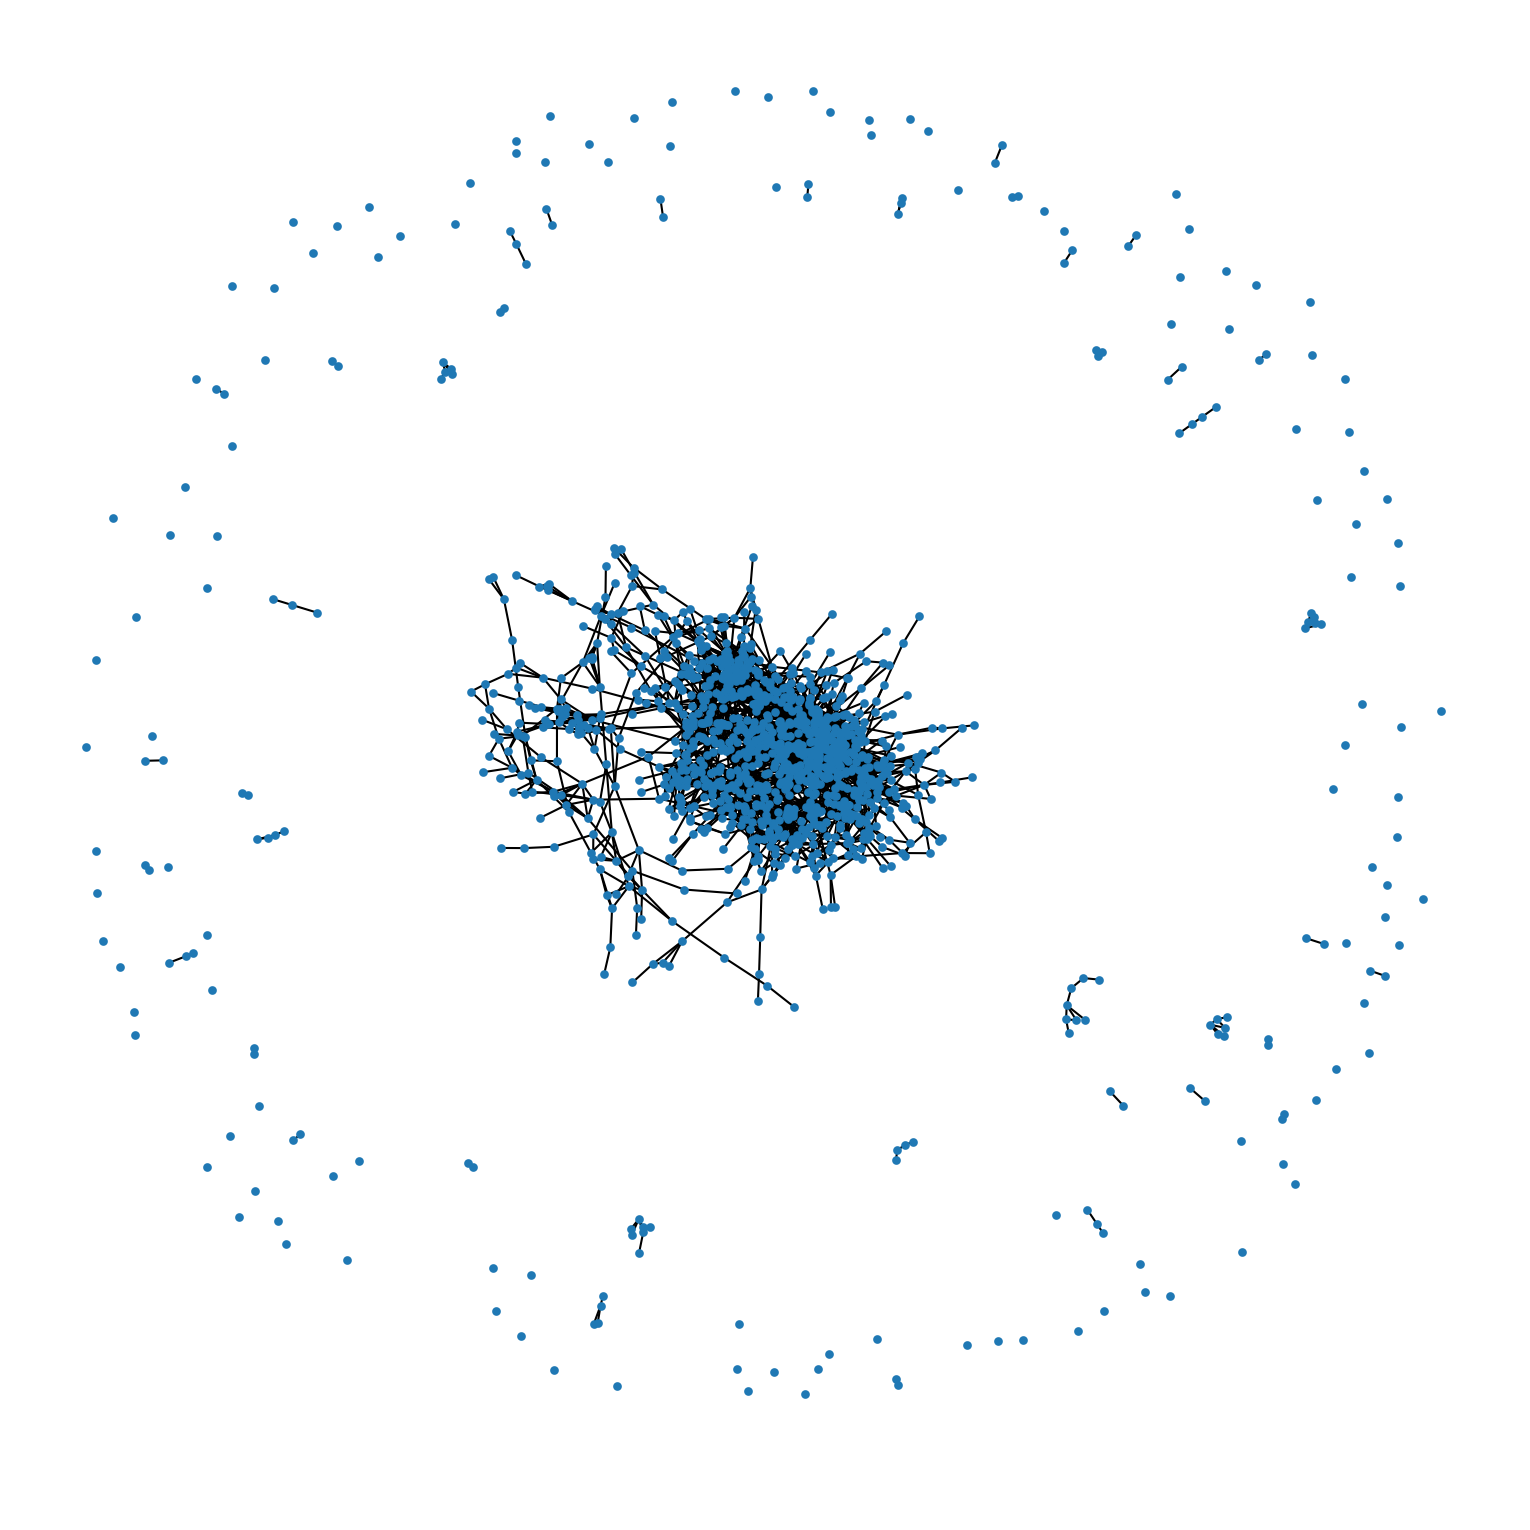

In [102]:
plt.figure(figsize=(10,10))
nx.draw(G4,node_size=10)
plt.savefig('WordNetwork_4_log12.png',dpi=150)